In [75]:
import numpy as np
import requests as r
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [76]:
def get_table_data(data, event_map:dict):
    assert data.shape[1] == 2
    filtered_data = []
    for i in range(data.shape[0]):
        num_people = event_map[data[i][0]]
        m,s = data[i][1].split(":")
        secs = round(int(m)*60 + float(s), 2) 
        speed_meters_per_second = 2000/secs
        filtered_data.append([num_people, speed_meters_per_second])
    return np.array(filtered_data)

In [77]:
def get_data(url = "https://en.wikipedia.org/wiki/List_of_world_best_times_in_rowing#On_water_records"):
    wiki_page_request = r.get(url)
    wiki_page_text = wiki_page_request.text
    soup = BeautifulSoup(wiki_page_text, 'html.parser')
    tables = soup.find_all('table')
    # get men and women tables
    event_map_men = {
    'M1x Single sculls': 1,
    'LM1x Lightweight single sculls':1,
    'M2- Coxless pairs':2,
    'LM2- Lightweight coxless pairs':2,
    'LM2x Lightweight double sculls':2,
    'M2+ Coxed pairs':2,
    'M2x Double sculls':2,
    'M4- Coxless four':4,
    'M4+ Coxed four': 4,
    'M4x Quad sculls':4,
    'LM4- Lightweight coxless four':4,
    'LM4x Lightweight quad sculls':4,
    'M8+ Eight':8,
    'LM8+ Lightweight eight':8
    }
    event_map_women = {
    'W1x Single sculls':1,
    'W2- Coxless pairs':2,
    'W2x Double sculls':2,
    'W4- Coxless four':4,
    'W4x Quad sculls':4,
    'W8+ Eight':8,
    'LW1x Lightweight single sculls':1,
    'LW2- Lightweight coxless pairs':2,
    'LW2x Lightweight double sculls':2,
    'LW4x Lightweight quadruple sculls':4
    }
    events = ["men", "women"]
    event_maps = [event_map_men, event_map_women]
    data_table = {}
    for i in range(2):
        required_table = tables[i]
        headers = [header.text.strip() for header in required_table.find_all('th')]
        rows = []
        # Find all `tr` tags
        data_rows = required_table.find_all('tr')
        for row in data_rows:
            value = row.find_all('td')
            beautified_value = [ele.text.strip() for ele in value]
            # Remove data arrays that are empty
            if len(beautified_value) == 0:
                continue
            rows.append(beautified_value)
        data = np.array(rows)
        data = data[:, :2]
        data_table[events[i]] = get_table_data(data, event_maps[i])
    return data_table

In [78]:
data_table = get_data()

In [79]:
def get_line_fit(x,y):
    # determine best fit line
    fit_params = np.polyfit(x, y, 1, full=False)
    beta, c = fit_params
    return beta,c
# scatter plot N vs time
def plot_fitted_line(x_data:list, y_data:list, plot_data:dict = None, save = False, plot_log = False):
    beta, log10c = get_line_fit(np.log10(x_data), np.log10(y_data))
    fig = plt.figure()
    ax = plt.gca()
    if plot_log:
        x_fit = np.logspace(min(x_data), max(y_data), 1000)
        y_fit = beta*x_fit + log10c
    else:
        x_fit = np.linspace(min(x_data), max(y_data), 10000)
        y_fit = 10**(log10c)*x_fit**(beta) 
    ax.plot(x_fit, y_fit, label = f'y = {10**(log10c):.3f} x^{beta: .3f}')
    ax.plot(x_data ,y_data, 'o', c='red', alpha=1.0, markeredgecolor='none', label = "data")
    if plot_data is None:
        ax.set_xlabel("weight_classes")
        ax.set_ylabel("competiton")
        ax.set_title("competition vs weight classes")
    else:
        ax.set_xlabel(plot_data["xlabel"])
        ax.set_ylabel(plot_data["ylabel"])
        ax.set_title(plot_data["title"])
        ax.set_xlim([min(x_data), max(x_data)])
        ax.set_ylim([min(y_data), max(y_data)])
    plt.legend()
    if save:
        plt.savefig(plot_data["title"]+".png")
    plt.show()

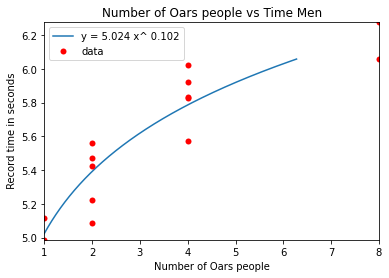

In [80]:
plot_data = {}
plot_data["xlabel"] = "Number of Oars people"
plot_data["ylabel"] = " Record time in seconds"
plot_data["title"] = "{} vs {} Men".format("Number of Oars people", "Time" )
plot_fitted_line(data_table["men"][:,0], data_table["men"][:,1], plot_data, save = True)


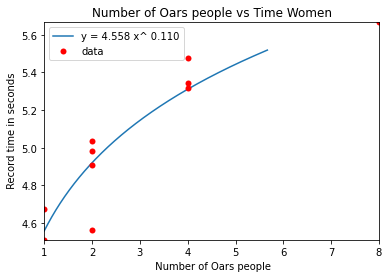

In [81]:
plot_data = {}
plot_data["xlabel"] = " Number of Oars people"
plot_data["ylabel"] = " Record time in seconds"
plot_data["title"] = "{} vs {} Women".format("Number of Oars people", "Time" )
plot_fitted_line(data_table["women"][:,0], data_table["women"][:,1], plot_data, save = True)

# Keplers law plot period vs distance of circular orbit
# $\tau^{2}$ versus $r^{3}$

In [82]:
orbital_period_days = np.array([88.0, 224.7, 365.2, 687.0, 4331, 10747, 30589, 59800, 90560])
orbital_period_yrs = orbital_period_days/365.2
radius_orbit_AU = np.array([0.4, 0.7, 1.0, 1.5, 5.2, 9.6, 19.2, 30.0, 39.5])

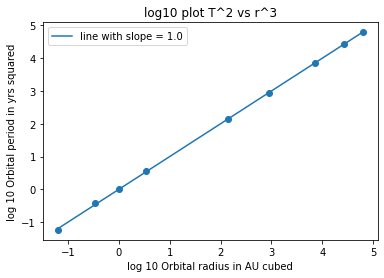

In [100]:
x_data = np.power(radius_orbit_AU, 3)
y_data = np.power(orbital_period_yrs, 2)
fig, ax = plt.subplots()
ax.scatter(np.log10(x_data), np.log10(y_data))
ax.set_xlabel("log 10 Orbital radius in AU cubed")
ax.set_ylabel("log 10 Orbital period in yrs squared")
ax.set_title("log10 plot T^2 vs r^3")
#find line of best fit
a, b = np.polyfit(np.log10(x_data), np.log10(y_data), 1)
ax.plot(np.log10(x_data), a*np.log10(x_data)+b, label = "line with slope = "+str(round(a,2)))
plt.legend()
plt.savefig("T^2_vs_r^3.png")
plt.show()